In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.metrics import f1_score as score #Scoring metric for the competition
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import time
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
sns.set_palette("Set2")
sns.set_style("ticks")

In [6]:
train_labels = pd.read_csv('train_labels.csv')
train_values = pd.read_csv('train_values.csv')
test_values  = pd.read_csv('test_values.csv')
train_labels.head()



,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [7]:
print("# Train Values: {}".format(train_values.shape))
print("# Train Labels: {}".format(train_labels.shape))
print("# Test Values: {}".format(test_values.shape))

# Train Values: (260601, 39)
# Train Labels: (260601, 2)
# Test Values: (86868, 39)


## **Missing Values**

In [11]:
train_values.isnull().sum() * 100 / len(train_values)

train_labels.isnull().sum() * 100 / len(train_values)

test_values.isnull().sum() * 100 / len(train_values)


building_id                               0.0
geo_level_1_id                            0.0
geo_level_2_id                            0.0
geo_level_3_id                            0.0
count_floors_pre_eq                       0.0
age                                       0.0
area_percentage                           0.0
height_percentage                         0.0
land_surface_condition                    0.0
foundation_type                           0.0
roof_type                                 0.0
ground_floor_type                         0.0
other_floor_type                          0.0
position                                  0.0
plan_configuration                        0.0
has_superstructure_adobe_mud              0.0
has_superstructure_mud_mortar_stone       0.0
has_superstructure_stone_flag             0.0
has_superstructure_cement_mortar_stone    0.0
has_superstructure_mud_mortar_brick       0.0
has_superstructure_cement_mortar_brick    0.0
has_superstructure_timber         


The dataset looks very clean and we don't seem to have any missing data.

## Data Spread

Let's estimate how balanced the datasets are 

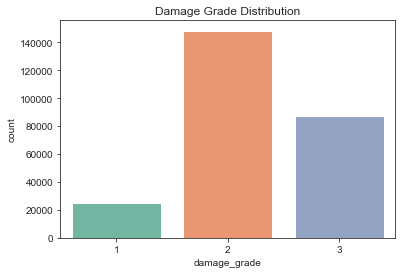

In [13]:
sns.countplot(x="damage_grade", data=train_labels)
plt.title("Damage Grade Distribution")
plt.show()

From the previous plot, it is easy to see that our dataset is very imbalanced. The reason why this dataset is imbalanced could be due to the fact that the data was collected after the 2015 Nepal's Earthquake, and it is very likely that the damage grade of the buildings is highly correlated to the intensity of the earthquake. It is important to mention that decision trees and random forests are extremely sensitive to imbalanced data. 

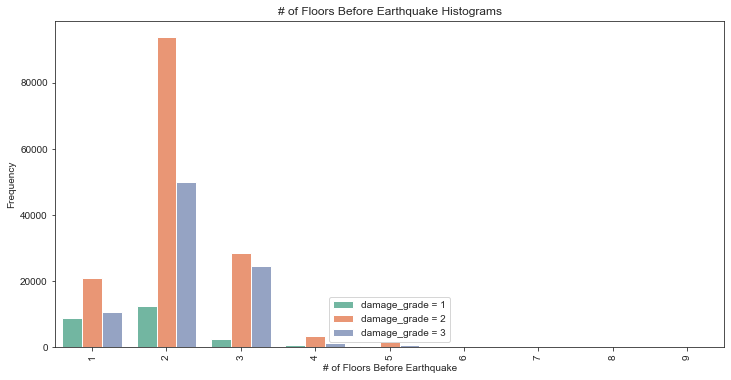

In [14]:
plt.figure(figsize=(12,6))
sns.countplot(train_values["count_floors_pre_eq"], hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("# of Floors Before Earthquake")
plt.xticks(rotation=90)
plt.title("# of Floors Before Earthquake Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

There are buildings in the dataset with up to 9 floors, but the majority of the affect had only 2.

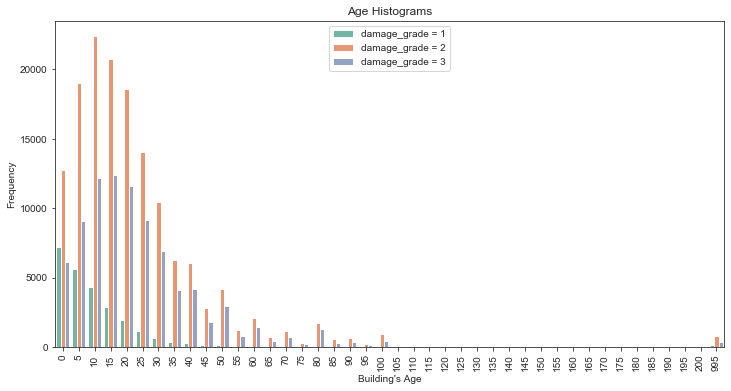

In [15]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_values["age"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Building's Age")
plt.xticks(rotation=90)
plt.title("Age Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

We have buildings around 995 years old, which at first glance seems like a error in the collection of data. After a quick Google search, I was able to determine that buildings in Nepal can be that old. Nevertheless, we still have to deal with the outliers.

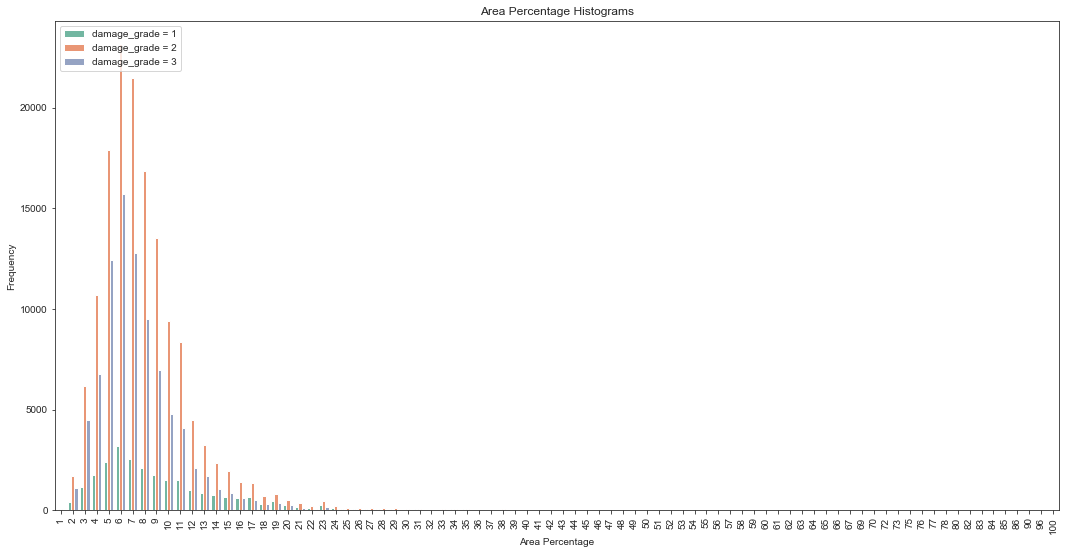

In [16]:
plt.figure(figsize=(18,9))
sns.countplot(x=train_values["area_percentage"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Area Percentage")
plt.xticks(rotation=90)
plt.title("Area Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

The normalized area of the building footprint is less than 20% for most buildings. It is important to mention that some values go up to 100%, so it is important for us to take care of the outliers of this feature.

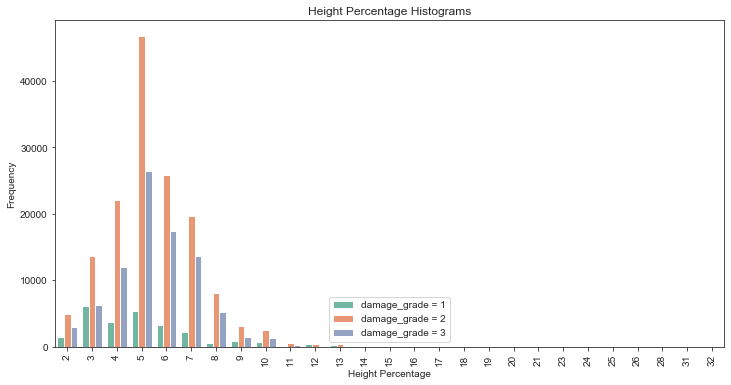

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x=train_values["height_percentage"],hue=train_labels["damage_grade"])
plt.ylabel("Frequency")
plt.xlabel("Height Percentage")
plt.xticks(rotation=90)
plt.title("Height Percentage Histograms")
plt.legend(["damage_grade = 1","damage_grade = 2","damage_grade = 3"])
plt.show()

Once again, we have another variable that needs to have its outliers removed. Most of the data for this feature is less than 10%, but we have some buildings with values up to 32%.

## Outliers

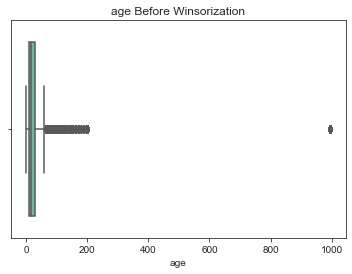

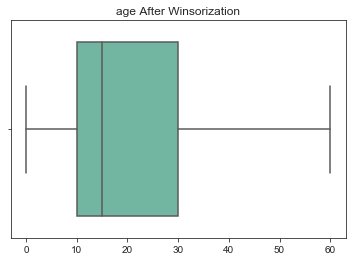

In [24]:
#Data source
name = "age"
data = train_values[name]

#Before winsorization
sns.boxplot(data)
plt.title("{} Before Winsorization".format(name))
plt.show()

#Winsorization
winsorized_data = winsorize(data,(0, 0.05))

#After winsorization
sns.boxplot(winsorized_data)
plt.title("{} After Winsorization".format(name))
plt.show()

#Replace data in dataset
train_values[name] = winsorized_data

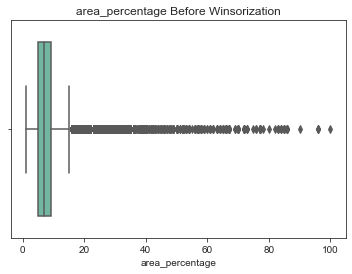

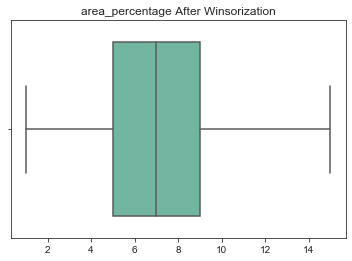

In [25]:
#Data source
name = "area_percentage"
data = train_values[name]

#Before winsorization
sns.boxplot(data)
plt.title("{} Before Winsorization".format(name))
plt.show()

#Winsorization
winsorized_data = winsorize(data,(0, 0.055))

#After winsorization
sns.boxplot(winsorized_data)
plt.title("{} After Winsorization".format(name))
plt.show()

#Replace data in dataset
train_values[name] = winsorized_data

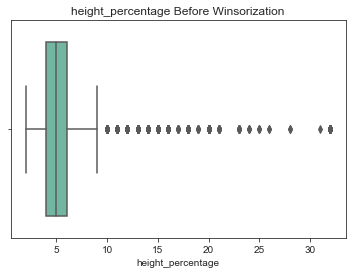

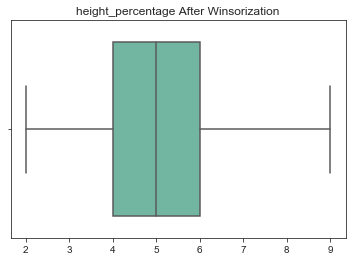

In [26]:
#Data source
name = "height_percentage"
data = train_values[name]

#Before winsorization
sns.boxplot(data)
plt.title("{} Before Winsorization".format(name))
plt.show()

#Winsorization
winsorized_data = winsorize(data,(0, 0.04))

#After winsorization
sns.boxplot(winsorized_data)
plt.title("{} After Winsorization".format(name))
plt.show()

#Replace data in dataset
train_values[name] = winsorized_data

In [18]:
train_values.drop(columns=["building_id"], inplace=True)
train_labels.drop(columns=["building_id"], inplace=True)

In [19]:
train_values = pd.get_dummies(train_values, drop_first = True)

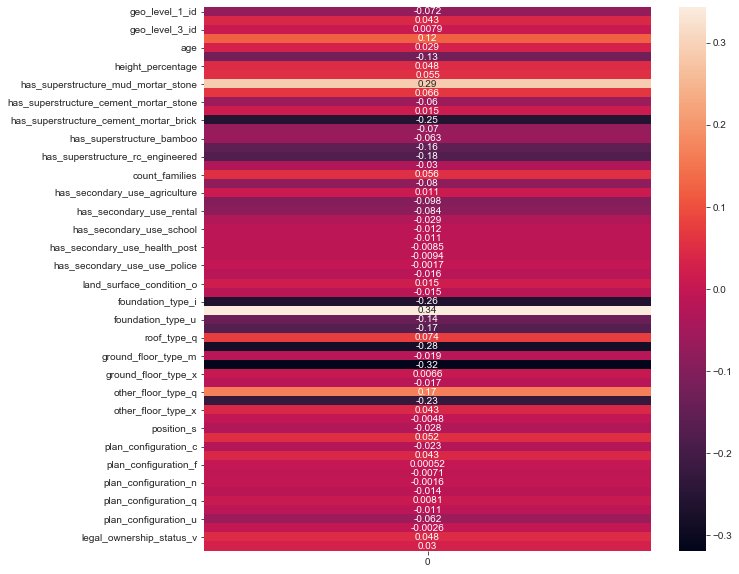

In [20]:
plt.figure(figsize=(10,10))
correlations = train_values.corrwith(train_labels["damage_grade"])
sns.heatmap(pd.DataFrame(correlations), annot=True)
plt.show()

As it was previously mentioned, our dataset is very imbalanced and mainly contains *damage_grade = 2* values. Random forests and decision trees are highly sensitive to outliers, so fixing this issue should be a priority. RandomForestClassifier has a setting that let us deal with class imbalances named "class_weight." By setting class_weight = "balanced", the classes will be automatically weighted inversely proportional to the frequency in which they appear in the dataset. After some trial and error I determined that class_weight = "balanced" will no yield as good results as class_weight = None, because it is very likely that the test data is imbalanced as well.
Let's now compare the score of a single decision tree against that of a random forest. For both models, I'll use the best parameters previously obtained through GridSearchCV (ran in my own machine to speed up the process). I'll use the module time to compare if the added complexity and extra calculation time of the random forest is justified by a better score.

In [22]:
X = train_values
y = train_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#Decision Tree
dt = DecisionTreeClassifier(max_features = None,
                            max_depth = 45,
                            min_samples_split = 3,
                            min_samples_leaf = 30,
                            random_state=42)
start_time = time.time()
model = dt.fit(X_train, y_train)
dt_time_fit = time.time() - start_time

#Predictions - Decision Tree
start_time = time.time()
model.predict(X_test)
dt_time_pred = time.time() - start_time
print("Decision Tree")
print("Fit Time: {} seconds".format(dt_time_fit))
print("Prediction Time: {} seconds".format(dt_time_pred))
print("Training Score: {}".format(dt.score(X_train, y_train)))
print("Test Score: {}".format(dt.score(X_test, y_test)))
print("----------------------------------------")

#Random Forest
rf = RandomForestClassifier(max_features = None,
                            max_depth = 45,
                            min_samples_split = 3,
                            min_samples_leaf = 30,
                            random_state=42)
start_time = time.time()
model = rf.fit(X_train, y_train)
rf_time_fit = time.time() - start_time

#Predictions - Decision Tree
start_time = time.time()
model.predict(X_test)
rf_time_pred = time.time() - start_time
print("Random Forest")
print("Fit Time: {} seconds".format(rf_time_fit))
print("Prediction Time: {} seconds".format(rf_time_pred))
print("Training Score: {}".format(rf.score(X_train, y_train)))
print("Test Score: {}".format(rf.score(X_test, y_test)))

Decision Tree
Fit Time: 4.799106597900391 seconds
Prediction Time: 0.06391191482543945 seconds
Training Score: 0.748561013046815
Test Score: 0.7163715201166516
----------------------------------------
Random Forest
Fit Time: 306.1161639690399 seconds
Prediction Time: 2.065955400466919 seconds
Training Score: 0.755132386799693
Test Score: 0.7308186719364556


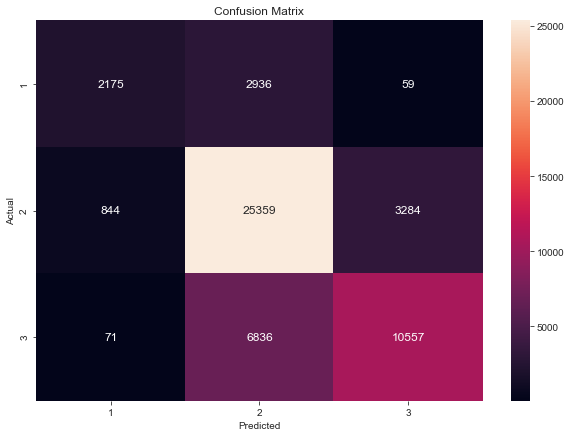

In [23]:
y_pred = rf.predict(X_test)

data = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix")
plt.show()

## Feature Importance

In [27]:
results = list(zip(X, rf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
importance

,Feature,Importance
0,geo_level_1_id,0.369038
1,geo_level_2_id,0.189168
33,foundation_type_r,0.105420
2,geo_level_3_id,0.089346
4,age,0.041084
5,area_percentage,0.032276
8,has_superstructure_mud_mortar_stone,0.028365
6,height_percentage,0.022356
42,other_floor_type_q,0.015535
32,foundation_type_i,0.012779


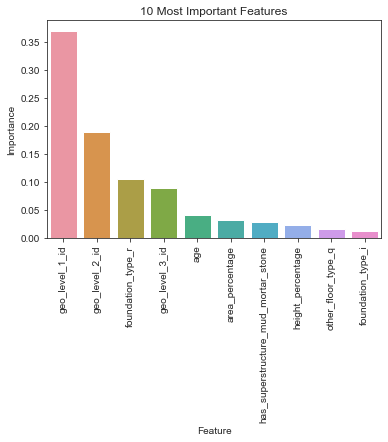

In [28]:
importance_10 = importance.head(10)
plot = sns.barplot(x=importance_10["Feature"], y=importance_10["Importance"])
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.title("10 Most Important Features")
plt.show()